3rd Gaussian Momento Skewness for lc 6: -1.40
4th Gaussian Moment Kurtosis for lc 6: 4.84
3rd Gaussian Momento Skewness for lc 8: -1.23
4th Gaussian Moment Kurtosis for lc 8: 4.41
3rd Gaussian Momento Skewness for lc 10: -0.64
4th Gaussian Moment Kurtosis for lc 10: 10.13
3rd Gaussian Momento Skewness for lc 12: -0.30
4th Gaussian Moment Kurtosis for lc 12: 6.03


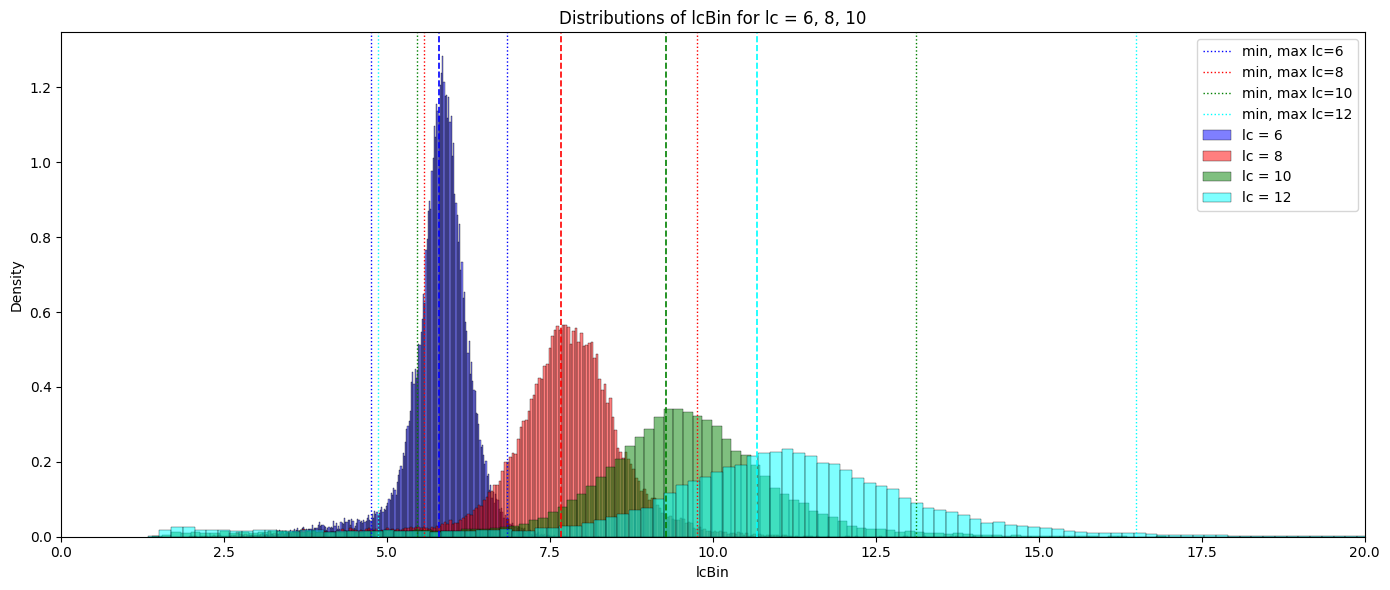

In [19]:
### Exploratory Data Analysis ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

bins=300
data = pd.read_csv('/home/chris/projects/ml-permeability-prediction/raw_data/ind_output_3D_v4.csv')

def calculate_stats(data, lc_value, column='lcBin'):
    subset = data[data['lc'] == lc_value]
    mean = subset[column].mean()
    std = subset[column].std()
    minlim = mean - 2*std
    maxlim = mean + 2*std
    skewness = skew(subset[column])
    kurt = kurtosis(subset[column])
    return subset, mean, std, minlim, maxlim, skewness, kurt

lc_values = [6,8,10,12]

stats = {}
for lc in lc_values:
    stats[lc] = calculate_stats(data, lc)

# Filter data by connectivity structure
data_ics = data[data['con'] == 1]
data_hcs = data[data['con'] == 2]
data_lcs = data[data['con'] == 3]

plt.figure(figsize=(14, 6))
colors = ['blue', 'red', 'green', 'cyan']
for i, lc in enumerate(lc_values):
    subset, mean, std, minlim, maxlim, skewness, kurt = stats[lc]
    sns.histplot(subset['lcBin'], bins=bins, kde=False, color=colors[i], alpha=0.5, label=f'lc = {lc}', stat="density")
    plt.axvline(x=mean, color=colors[i], linewidth=1.2, linestyle='--')  
    plt.axvline(x=minlim, color=colors[i], linewidth=1, linestyle=':', label=f'min, max lc={lc}')
    plt.axvline(x=maxlim, color=colors[i], linewidth=1, linestyle=':')
    print(f'3rd Gaussian Momento Skewness for lc {lc}: {skewness:.2f}')
    print(f'4th Gaussian Moment Kurtosis for lc {lc}: {kurt:.2f}')

plt.legend()
plt.xlabel('lcBin')
#plt.ylabel('Relative frequency')
plt.title(f'Distributions of lcBin for lc = {lc_values[0]}, {lc_values[1]}, {lc_values[2]}')#, {lc_values[3]}')
plt.xlim(0, 20) 
plt.tight_layout()
plt.show()

In [ ]:
### PDF Analysis ###


def filtering_method(method):
    if method == 1:
        def filter_STD(data, column='keff', std_factor=2):
            '''Filter data within a value of standard deviations'''
            log_data = np.log(data[column])
            mean = log_data.mean()
            std = log_data.std()
            filter_data = data[(log_data >= mean - std_factor*std) & (log_data <= mean + std_factor*std)]
            filter_data
            
            stats = {
                'mean': mean,
                'std': std,
                'skewness': skew(log_data),
                'kurtosis': kurtosis(log_data),
                'n_samples': len(filter_data)
            }
            return filter_data, stats

    elif method == 2:
        def filter_IQR(data, column='keff', iqr_factor=1.5):    # iqr_factor = 1.5 or 3
            '''Filter data using the Interquartile Range method. This is a robust method that isn't affected 
            by extreme values. IQR is ised to determine the "whisker" boundaries for outlier detection: 
            iqr_factor: 1.5 more aggressive filtering (mild outliers), 3.0 more conservative filtering (extreme outliers).'''
            log_data = np.log(data[column])
            q1 = log_data.quantile(0.25)
            q3 = log_data.quantile(0.75)
            iqr = q3 - q1
            
            lower_bound = q1 - iqr_factor * iqr
            upper_bound = q3 + iqr_factor * iqr
            
            filter_data = data[(log_data >= lower_bound) & (log_data <= upper_bound)]
            
            stats = {
                'median': log_data.median(),
                'q1': q1,
                'q3': q3,
                'iqr': iqr,
                'skewness': skew(log_data),
                'kurtosis': kurtosis(log_data),
                'n_samples': len(filter_data)
            }
            return filter_data, stats

    elif method == 3:
        def filter_MAD(data, column='keff', thresh=3.5):    
            '''Filter data using the Median Absolute Deviation method (MAD). MAD is a robust measure of statistical 
            dispersion that is more resilient to outliers than standard deviation. It's particularly useful for 
            non-normal distributions and when dealing with extreme values. Non-parametric: Doesn't assume normal 
            distribution, better for skewed data: works well with asymmetric distributions
                Parameters:
                    thresh=3.5: Conservative threshold for outlier detection, keep more points.
                    thresh=2.5: More aggressive filtering
                    Common range: 2.0 to 3.5
            '''
            log_data = np.log(data[column])
            median = log_data.median()
            mad = np.median(np.abs(log_data - median))
            modified_zscore = 0.6745 * (log_data - median) / mad
            
            filter_data = data[np.abs(modified_zscore) < thresh]
            
            stats = {
                'median': median,
                'mad': mad,
                'skewness': skew(log_data),
                'kurtosis': kurtosis(log_data),
                'n_samples': len(filter_data)
            }
            return filter_data, stats

    else:
        def filter_PERC(data, column='keff', lower_pct=1, upper_pct=99):
            '''Filter data using percentile cutoffs. This method directly removes data from the tails of the distribution'''
            log_data = np.log(data[column])
            lower_bound = np.percentile(log_data, lower_pct)
            upper_bound = np.percentile(log_data, upper_pct)
            
            filter_data = data[(log_data >= lower_bound) & (log_data <= upper_bound)]
            
            stats = {
                'median': log_data.median(),
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'skewness': skew(log_data),
                'kurtosis': kurtosis(log_data),
                'n_samples': len(filter_data)
            }
            return filter_data, stats

def plot_histogram(data, filter_data, bins, color, title, ax, show_stats=True):
    '''Plot histogram with original and filtered data'''
    # Plot original data
    sns.histplot(np.log(data['keff']), bins=bins, kde=False,
                color=color, alpha=0.50, stat="density", 
                label='Original', ax=ax, element='poly')
    
    # Plot filtered data
    '''sns.histplot(np.log(filtered_data['keff']), bins=bins, kde=True,
                color=color, alpha=0.75, stat="density", 
                label='Filtered (±2σ)', ax=ax)'''
    
    if show_stats:
        _, stats = filter_data(data)
        ax.axvline(stats['mean'], color=color, linestyle='--', 
                  label=f'Mean = {stats["mean"]:.2f}')
        ax.axvline(stats['mean'] - 2*stats['std'], color=color, linestyle=':')
        ax.axvline(stats['mean'] + 2*stats['std'], color=color, linestyle=':')
    
    ax.set_title(title)
    ax.set_xlabel('log(keff)')
    ax.set_ylabel('Density')
    ax.legend(fontsize='small')
    
    return ax

# Setup parameters
colors = ['green', 'red', 'blue', 'cyan']
bins = 300
lc_values = [6, 8, 10, 12]

# Create filtered datasets
filtered_data_lc = {}
for lc in lc_values:
    subset = data[data['lc'] == lc]
    filtered_subset, stats = filter_and_stats(subset)
    filtered_data_lc[lc] = (filtered_subset, stats)
    print(f"\nStatistics for lc = {lc}:")
    for key, value in stats.items():
        print(f"{key}: {value:.3f}")

# Plot overall distribution
fig, ax = plt.subplots(figsize=(10, 6))
full_filtered_data, full_stats = filter_and_stats(data)
plot_histogram(data, full_filtered_data, bins, 'gray', 
              'Overall Distribution of log(keff)', ax)
plt.tight_layout()
plt.show()

# Plot by lc value
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
for i, lc in enumerate(lc_values):
    filtered_subset, _ = filtered_data_lc[lc]
    plot_histogram(data[data['lc'] == lc], filtered_subset, 
                  bins, colors[i], f'lc = {lc}', axs[i])
plt.suptitle('Distributions by lc value', y=1.05)
plt.tight_layout()
plt.show()

# Plot by connectivity structure
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
con_types = {'ICS': 1, 'HCS': 2, 'LCS': 3}
for i, (label, con_value) in enumerate(con_types.items()):
    subset = data[data['con'] == con_value]
    filtered_subset, _ = filter_and_stats(subset)
    plot_histogram(subset, filtered_subset, bins, colors[i], 
                  label, axs[i])
plt.suptitle('Distributions by Connectivity Structure', y=1.05)
plt.tight_layout()
plt.show()

filtering_method(1) # 1: STD, 2: IQR, 3: MAD, 4: PERC

In [13]:
### Exploratory Data Analysis ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

def calculate_stats_and_filter(data, lc_value, column='lcBin'):
    """Calculate statistics and filter data within ±2 standard deviations"""
    subset = data[data['lc'] == lc_value]
    mean = subset[column].mean()
    std = subset[column].std()
    std_filter = 3
    minlim = mean - std_filter*std
    maxlim = mean + std_filter*std
    
    # Filter data
    filtered_subset = subset[(subset[column] >= minlim) & 
                           (subset[column] <= maxlim)]
    
    # Calculate statistics for filtered data
    filtered_mean = filtered_subset[column].mean()
    filtered_std = filtered_subset[column].std()
    skewness = skew(filtered_subset[column])
    kurt = kurtosis(filtered_subset[column])
    
    stats = {
        'mean': filtered_mean,
        'std': filtered_std,
        'minlim': minlim,
        'maxlim': maxlim,
        'skewness': skewness,
        'kurtosis': kurt,
        'n_samples': len(filtered_subset),
        'removed_samples': len(subset) - len(filtered_subset)
    }
    
    return filtered_subset, stats

def plot_distributions(original_data, filtered_data, stats, colors, lc_values, bins):
    """Create side-by-side plots of original and filtered distributions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot original distributions
    for i, lc in enumerate(lc_values):
        subset = original_data[original_data['lc'] == lc]
        sns.histplot(data=subset, x='lcBin', bins=bins, kde=True,
                    alpha=0.5, label=f'lc = {lc}', color=colors[i],
                    stat="density", ax=ax1)  
    
    ax1.set_title('Original Distributions')
    ax1.set_xlabel('lcBin')
    ax1.set_ylabel('Density')
    ax1.set_xlim(0, 20)
    ax1.legend()
    
    # Plot filtered distributions
    for i, lc in enumerate(lc_values):
        filtered_subset = filtered_data[lc][0]
        stat = filtered_data[lc][1]
        
        sns.histplot(data=filtered_subset, x='lcBin', bins=bins, kde=True,
                    color=colors[i], alpha=0.5, label=f'lc = {lc}',
                    stat="density", ax=ax2)
        
        # Add mean and limit lines
        ax2.axvline(x=stat['mean'], color=colors[i], linestyle='--',
                   label=f'Mean (lc={lc})')
        ax2.axvline(x=stat['minlim'], color=colors[i], linestyle=':')
        ax2.axvline(x=stat['maxlim'], color=colors[i], linestyle=':')
        
        print(f"\nStatistics for lc = {lc} (filtered):")
        print(f"Mean: {stat['mean']:.2f}")
        print(f"Std Dev: {stat['std']:.2f}")
        print(f"Skewness: {stat['skewness']:.2f}")
        print(f"Kurtosis: {stat['kurtosis']:.2f}")
        print(f'Number of original samples: {len(subset)}')
        print(f'Number of filtered samples: {len(filtered_subset)}')
        print(f"Samples removed: {stat['removed_samples']} ({stat['removed_samples']/stat['n_samples']*100:.1f}%)")
    
    ax2.set_title('Filtered Distributions (±2 std. dev.)')
    ax2.set_xlabel('lcBin')
    ax2.set_ylabel('Density')
    ax2.set_xlim(0, 20)
    ax2.legend()
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Main execution
bins = 'auto'
data = pd.read_csv('csv back/ind_output_3D_v4_filtered.csv')
lc_values = [6, 8, 10, 12]
#colors = ['blue', 'red', 'green']

# Calculate statistics and filter data
filtered_data = {}
for lc in lc_values:
    filtered_subset, stats = calculate_stats_and_filter(data, lc)
    filtered_data[lc] = (filtered_subset, stats)

# Create plots
fig, axes = plot_distributions(data, filtered_data, stats, colors, lc_values, bins)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'csv back/ind_output_3D_v4_filtered.csv'


Statistics for lc = 6:
mean: nan
std: nan
skewness: nan
kurtosis: nan
n_samples: 0.000

Statistics for lc = 8:
mean: 2.373
std: 0.767
skewness: -0.588
kurtosis: -0.705
n_samples: 19234.000

Statistics for lc = 10:
mean: 2.321
std: 0.828
skewness: -0.558
kurtosis: -0.823
n_samples: 19379.000

Statistics for lc = 12:
mean: 2.263
std: 0.862
skewness: -0.496
kurtosis: -0.936
n_samples: 19599.000


/tmp/ipykernel_38653/360114757.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'skewness': skew(log_data),
/tmp/ipykernel_38653/360114757.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'kurtosis': kurtosis(log_data),


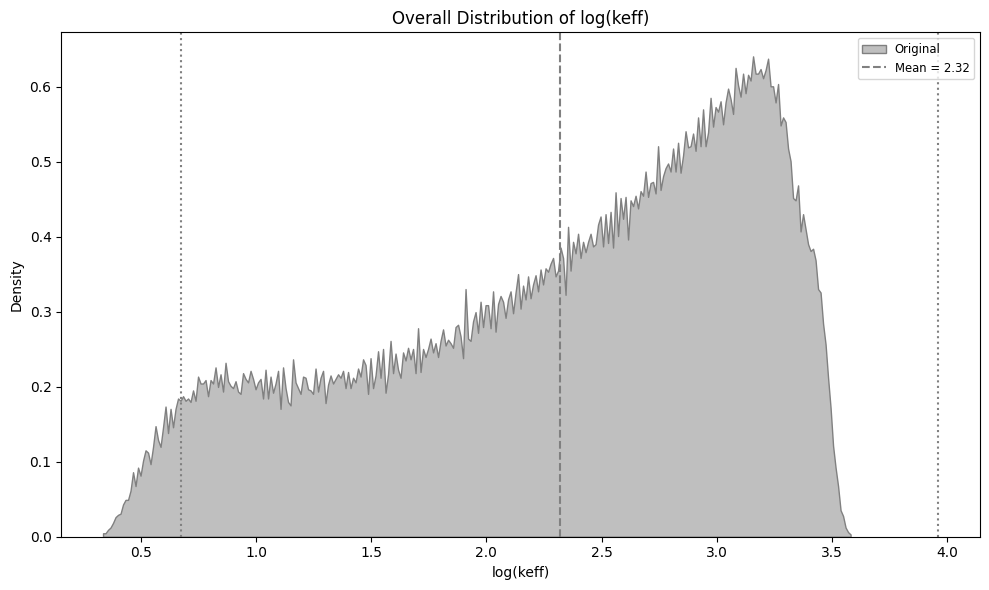

/tmp/ipykernel_38653/360114757.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'skewness': skew(log_data),
/tmp/ipykernel_38653/360114757.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'kurtosis': kurtosis(log_data),


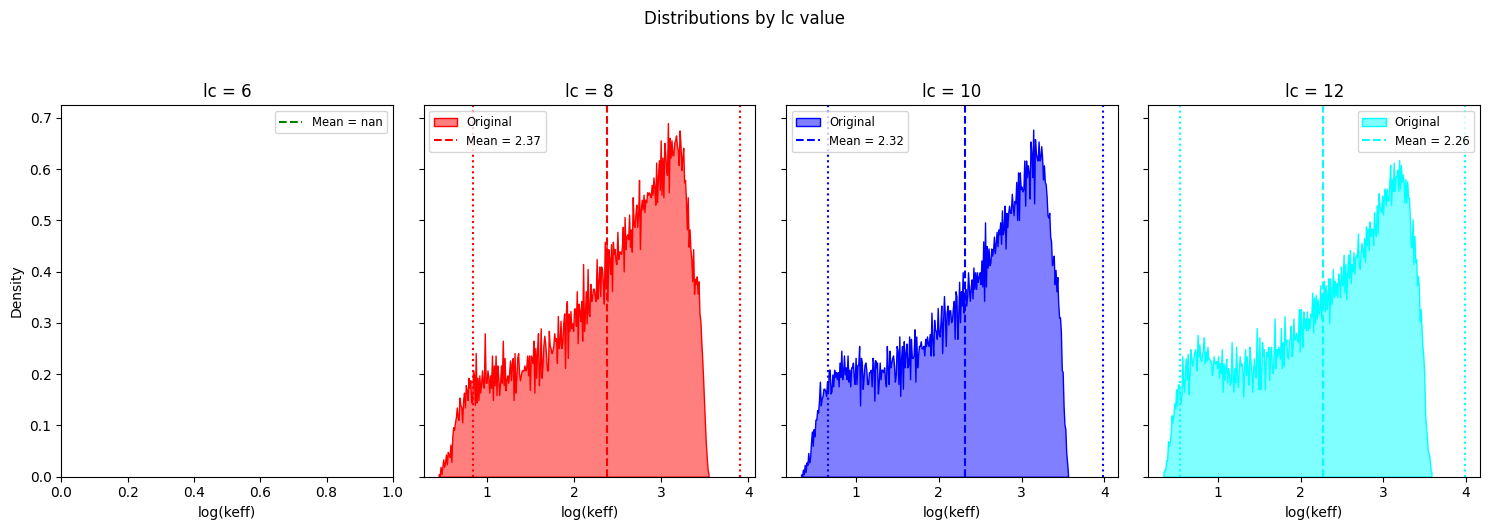

/tmp/ipykernel_38653/360114757.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'skewness': skew(log_data),
/tmp/ipykernel_38653/360114757.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'kurtosis': kurtosis(log_data),
/tmp/ipykernel_38653/360114757.py:19: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'skewness': skew(log_data),
/tmp/ipykernel_38653/360114757.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  'kurtosis': kurtosis(log_data),


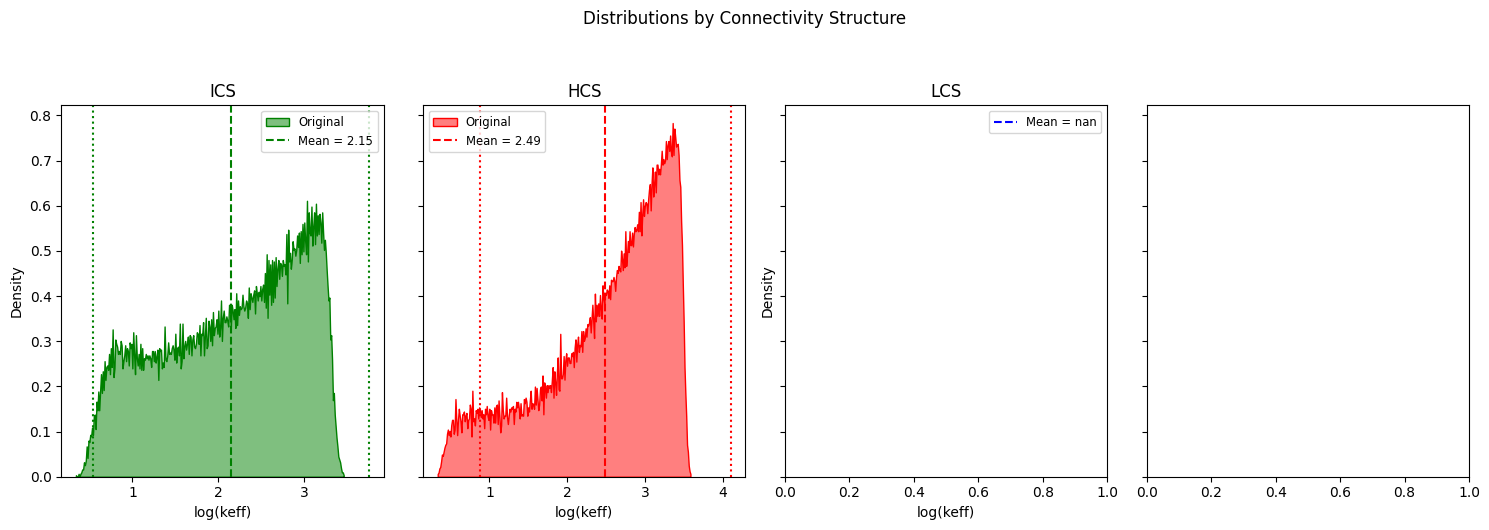

In [ ]:
### 2D pc = 0.593, para lc = 0, LCS pc poco mayor, ICS y HCS lc menor, a mayor lc menor pc.
### 3D pc = 0.312, para lc = 0, ICS, HCS, LCS pc menor, a mayor lc menor pc.

# prueba 1 3D: L=64, p=[10,50,1000], EC=1, var=1, ref=1, lc=2,3,4, real=1. 3D_test_1 - OK 3.5 h.

# prueba 2 3D: L=64, p=[10,50,1000], EC=2, var=1, ref=1, lc=2,3,4, real=1. 3D_test_2 - OK 3h 5 min.

# prueba 3 3D: L=64, p=[10,50,1000], EC=3, var=1, ref=1, lc=2,3,4, real=1. 3D_test_3 - Ok mas 4 horas

# los resultados no son buenos, sigue el mismo problema.



# prueba 3 3D: L=64, p=[10,50,1000], EC=1, var=1, ref=4, lc=2,3,4, real=1. 3D_test_ref - OK, no finaliza la simulacion en 3 dias solo 2200 real.

### (v3) lc=10 covarianza Gaussiana: se ven mejores resultados, las distribuciones son más uniformes: se realizan simulaciones de lc=6 y 8, el de 6 gneera un doble pico
### en las keff mas alta, para 8 el doble pico es menos pronunciado. Se decide realizar simulaciones de lc=12. En funcion de como salgan se utilizaran 8, 10 y 12.

# Prueba 5: L=64, p=[10,15,100], EC = 1, 2, 3, ref = 1, lc = 8, 10, 12, cov = gauss, seeds = 100, kl = 1, kh = 100
# Prueba 6: L=1024, p=[40,80,100], EC = 1, 2, 3, ref = 1, lc = 128, 160, 192, cov = gauss, seeds = 100, kl = 1, kh = 100

22 ['PPHA' 'VOLALE' 'ZNCC' 'GAMMA' 'spanning' 'npz' 'npy' 'npx' 'Plen' 'S'
 'P' 'PlenX' 'SX' 'PX' 'L' 'con' 'lc' 'p' 'lcG' 'lcNst' 'lcBin' 'keff']
10 ['PPHA' 'VOLALE' 'ZNCC' 'GAMMA' 'spanning' 'Plen' 'S' 'P' 'PlenX' 'lcBin']


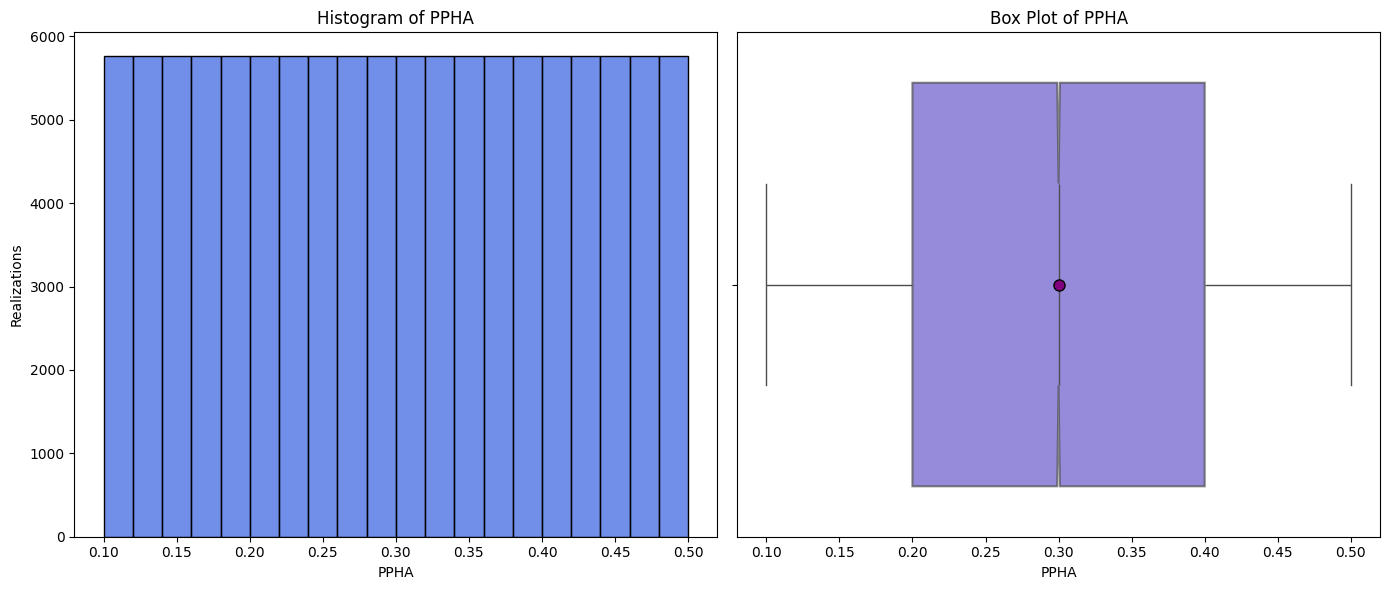

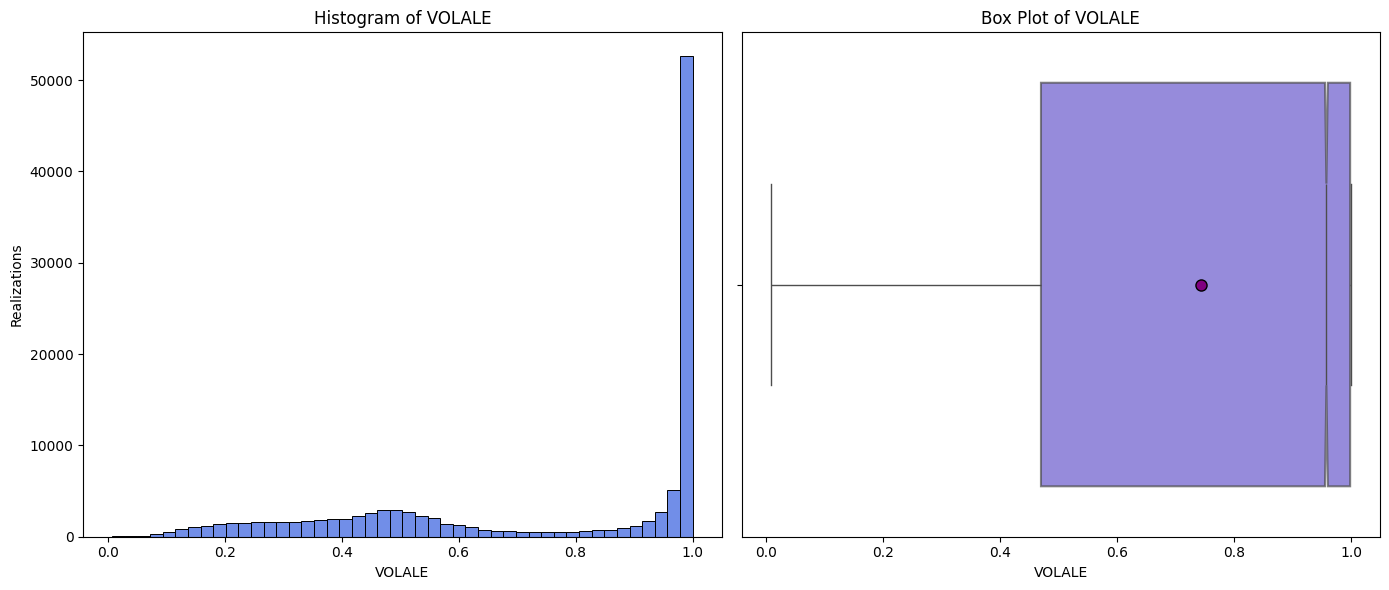

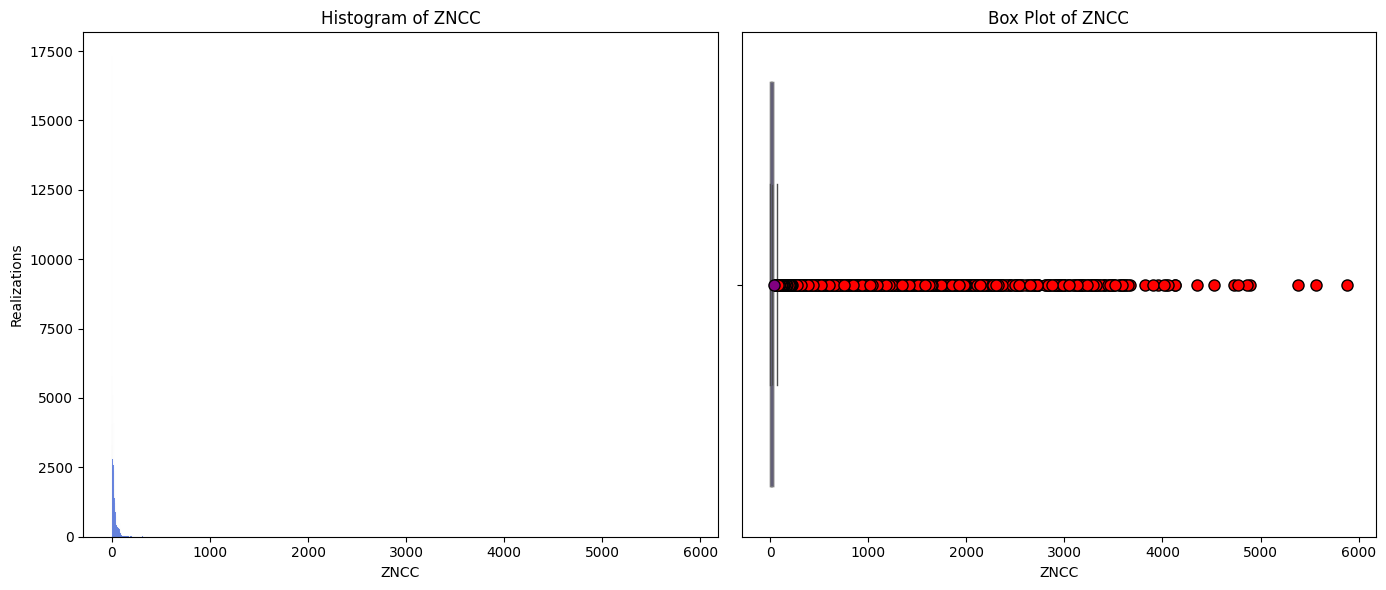

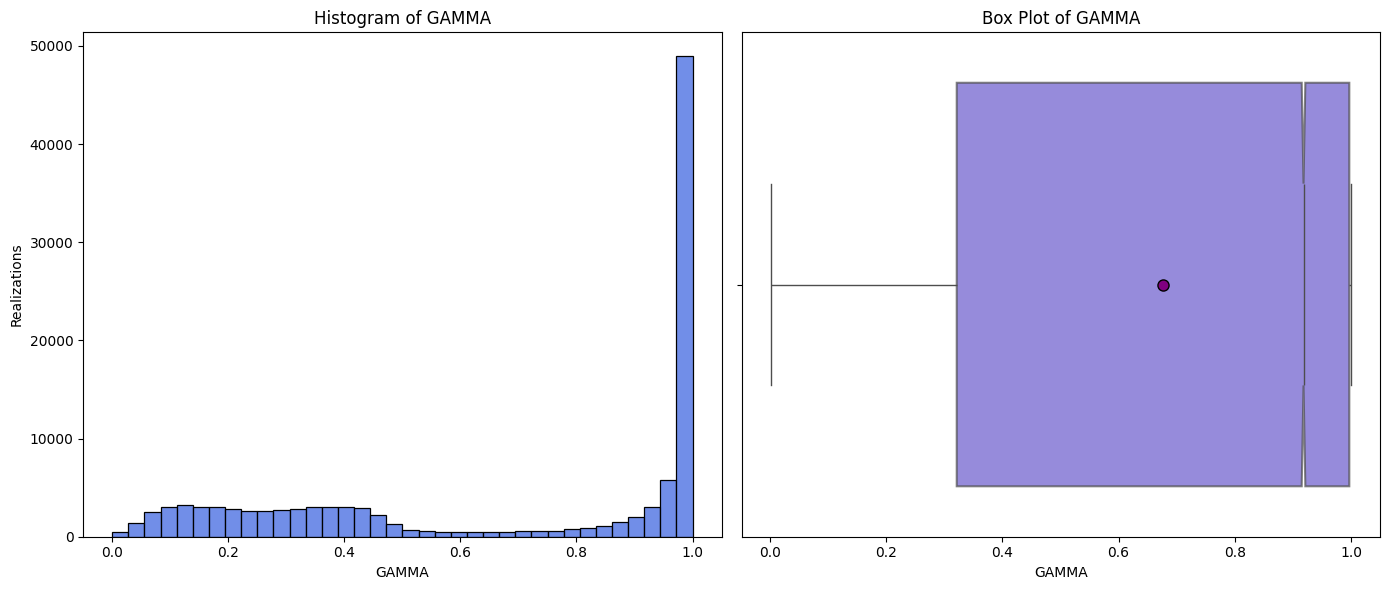

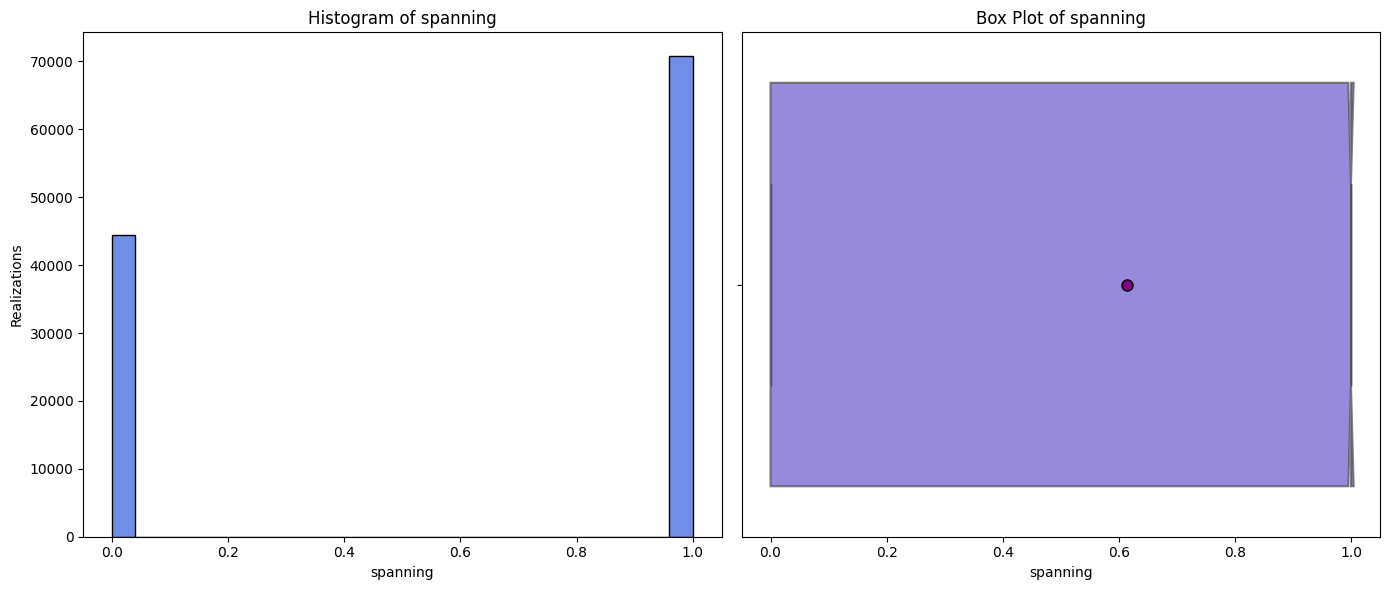

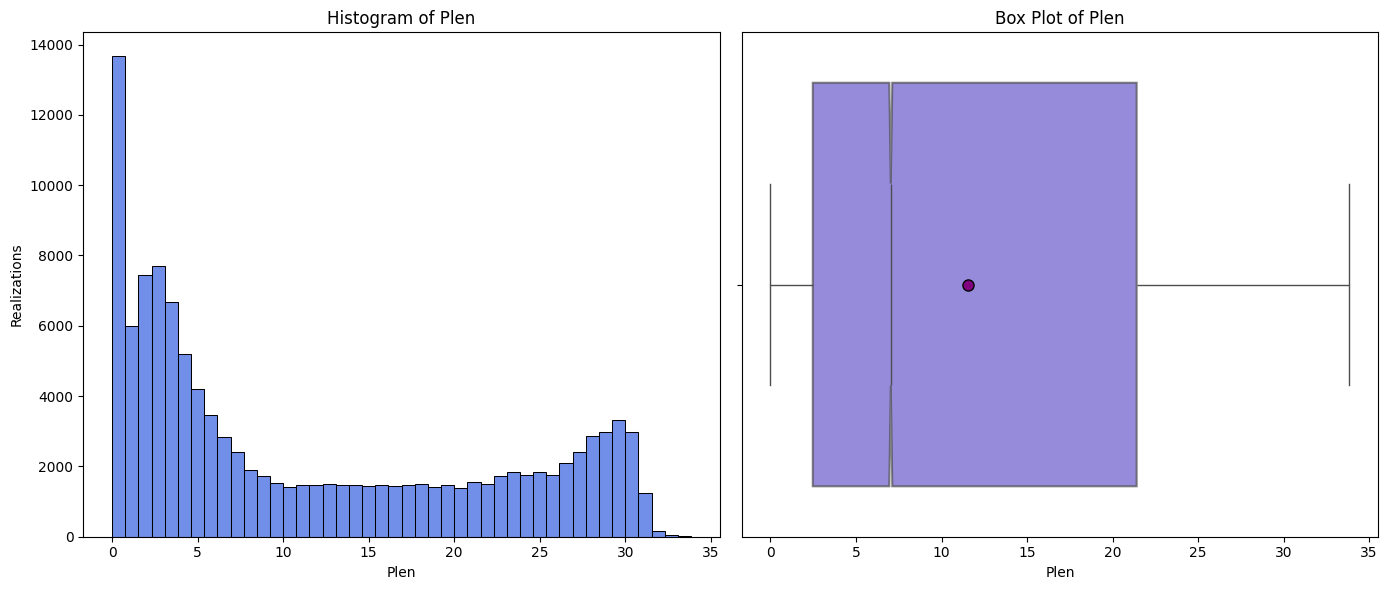

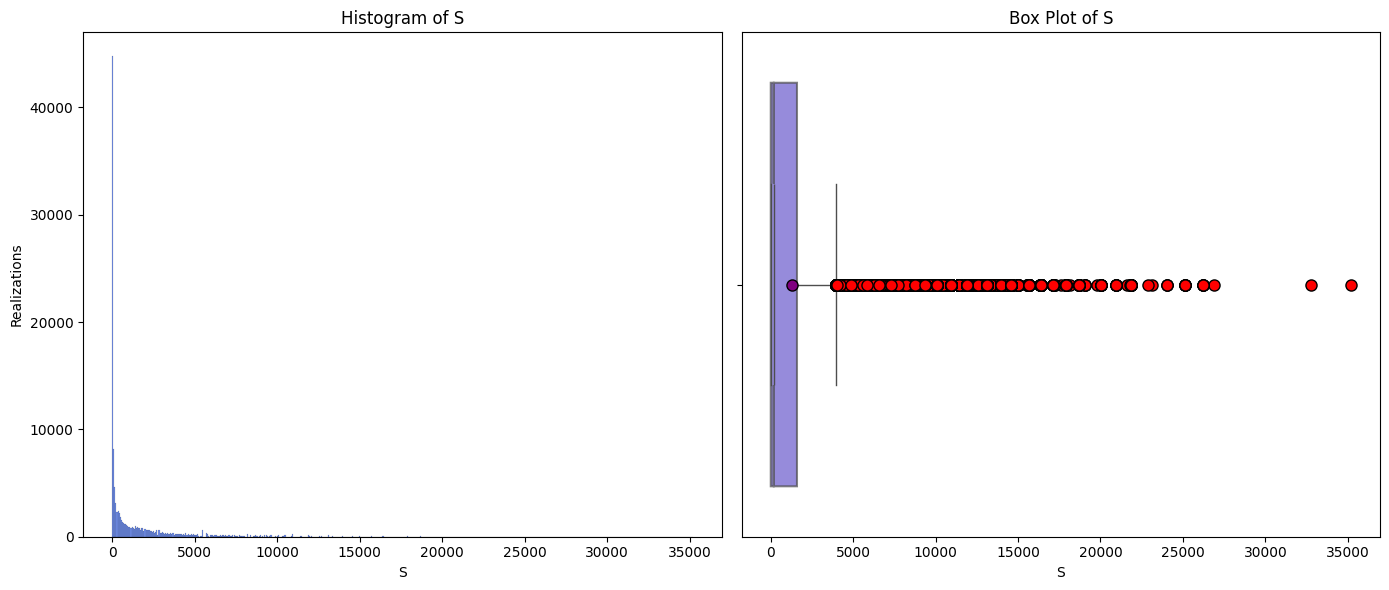

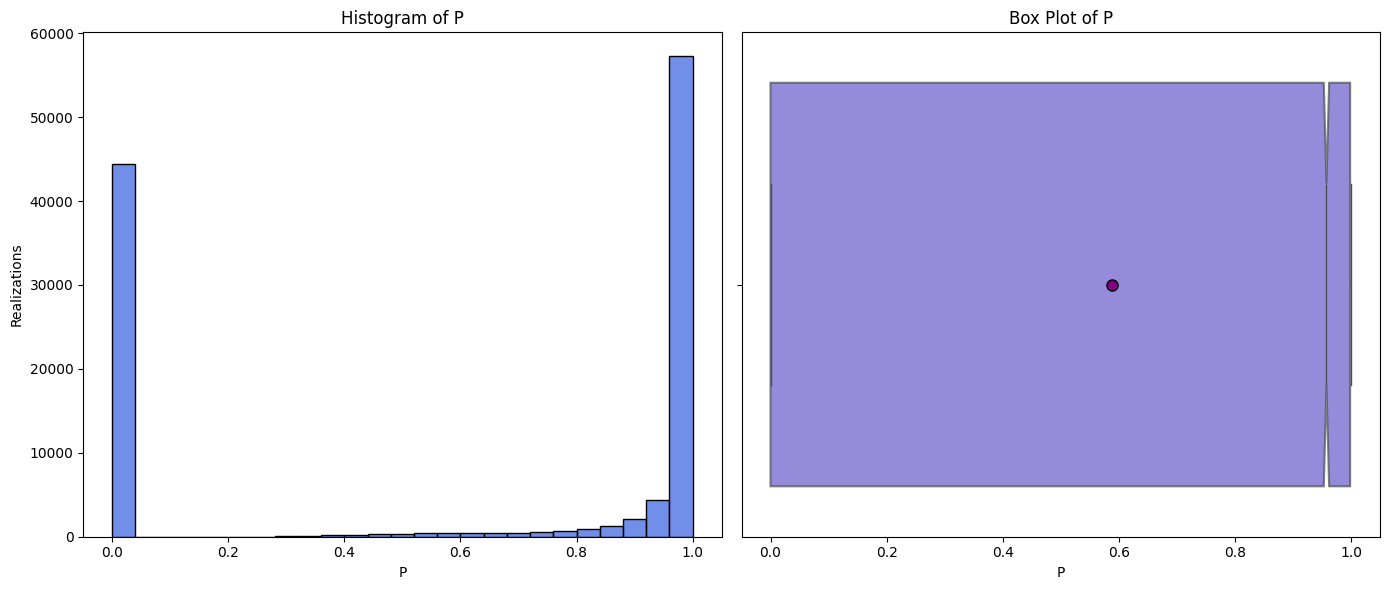

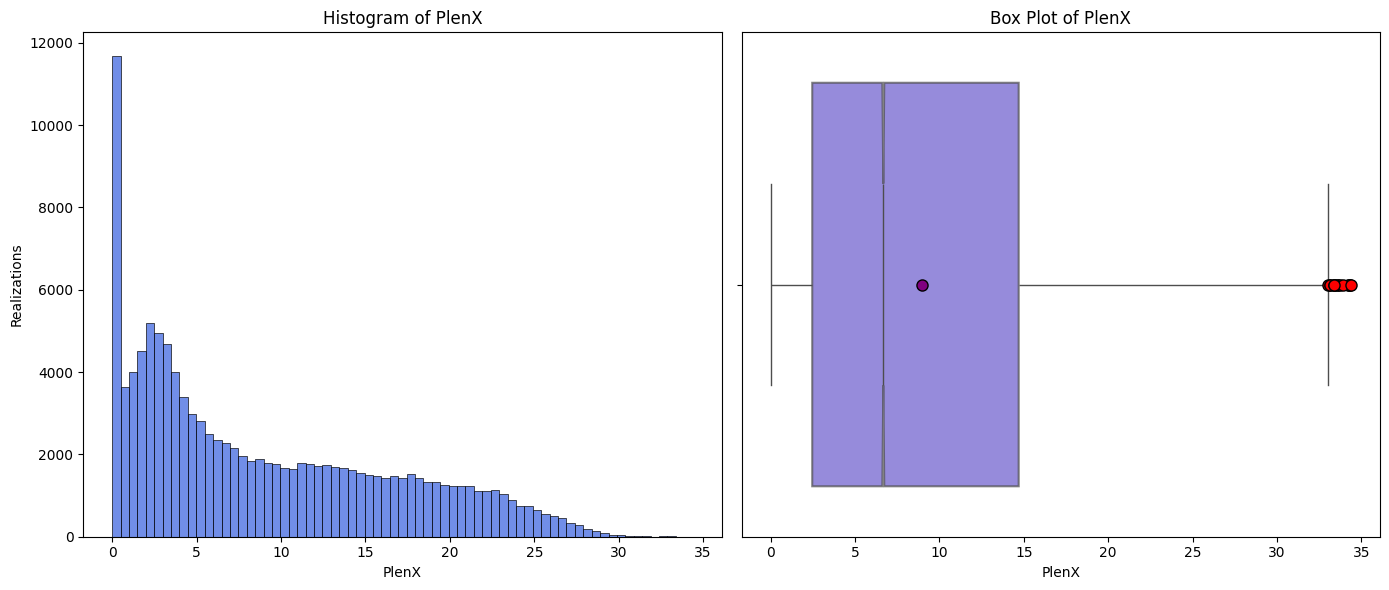

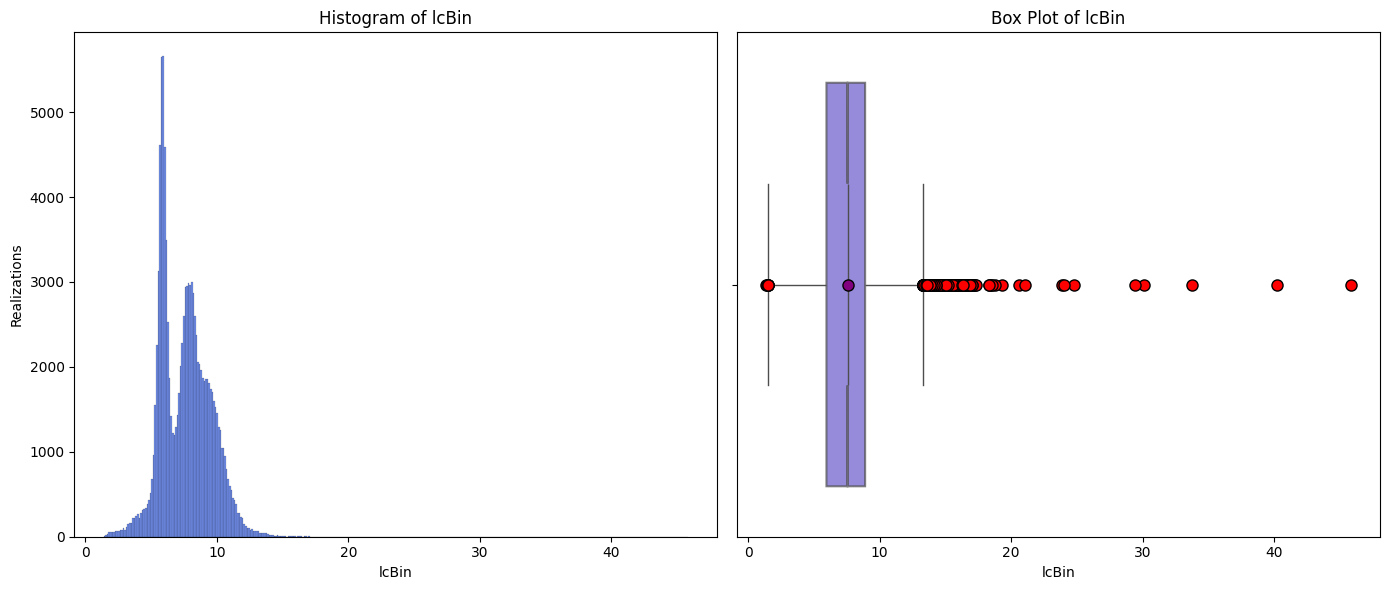

In [49]:
### Histograms and box plots of indicators ###
header = data.columns.to_numpy()
print(len(header), header)
delete = [5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 21]
data_ind = np.delete(header, delete)
print(len(data_ind), data_ind)

for ind in range(len(data_ind)):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    if data_ind[ind] == 'PPHA':
        bins = 20
    else:
        bins = 'auto'

    sns.histplot(data[data_ind[ind]], 
                    bins=bins, kde=False, 
                    color='royalblue', stat="count", 
                    fill=True, 
                    label=data_ind[ind],
                    alpha=0.75, ax=axs[0])
    axs[0].set_ylabel('Realizations')
    axs[0].set_xlabel(data_ind[ind])
    axs[0].set_title(f'Histogram of {data_ind[ind]}')

    sns.boxplot(x=data[data_ind[ind]], color='cyan', ax=axs[1], notch=True, showmeans=True,
                meanprops={'marker':'o', 'markerfacecolor':'purple', 'markeredgecolor':'black', 'markersize':8},
                flierprops={'marker':'o', 'markerfacecolor':'red', 'markeredgecolor':'black', 'markersize':8},
                boxprops={'facecolor':'slateblue', 'linewidth':1.5, 'alpha':0.7})
    axs[1].set_xlabel(data_ind[ind])
    axs[1].set_title(f'Box Plot of {data_ind[ind]}')

    plt.tight_layout()
    plt.show()